In [1]:
import os
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Reading and processing dataset 

In [3]:
dataset_root = 'NSL-KDD-Dataset'

In [4]:
train_file = os.path.join(dataset_root, 'KDDTrain+.txt')
test_file = os.path.join(dataset_root, 'KDDTest+.txt')

In [5]:
# Original KDD dataset feature names obtained from 
# http://kdd.ics.uci.edu/databases/kddcup99/kddcup.names
# http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html

header_names = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack_type', 'success_pred']

In [6]:
# Differentiating between nominal, binary, and numeric features

# root_shell is marked as a continuous feature in the kddcup.names 
# file, but it is supposed to be a binary feature according to the 
# dataset documentation

col_names = np.array(header_names)

nominal_idx = [1, 2, 3]
binary_idx = [6, 11, 13, 14, 20, 21]
numeric_idx = list(set(range(41)).difference(nominal_idx).difference(binary_idx))

nominal_cols = col_names[nominal_idx].tolist()
binary_cols = col_names[binary_idx].tolist()
numeric_cols = col_names[numeric_idx].tolist()

In [7]:
# training_attack_types.txt maps each of the 22 different attacks to 1 of 4 categories
# file obtained from http://kdd.ics.uci.edu/databases/kddcup99/training_attack_types

category = defaultdict(list)
category['benign'].append('normal')

with open('NSL-KDD-Dataset/training_attack_types.txt', 'r') as f:
    for line in f.readlines():
        attack, cat = line.strip().split(' ')
        category[cat].append(attack)

attack_mapping = dict((v,k) for k in category for v in category[k])

## Generating and analyzing train and test sets

In [8]:
train_df = pd.read_csv(train_file, names=header_names)
train_df['attack_category'] = train_df['attack_type'] \
                                .map(lambda x: attack_mapping[x])
train_df.drop(['success_pred'], axis=1, inplace=True)
    
test_df = pd.read_csv(test_file, names=header_names)
test_df['attack_category'] = test_df['attack_type'] \
                                .map(lambda x: attack_mapping[x])
test_df.drop(['success_pred'], axis=1, inplace=True)

In [9]:
train_attack_types = train_df['attack_type'].value_counts()
train_attack_cats = train_df['attack_category'].value_counts()

In [10]:
test_attack_types = test_df['attack_type'].value_counts()
test_attack_cats = test_df['attack_category'].value_counts()

<Axes: ylabel='attack_type'>

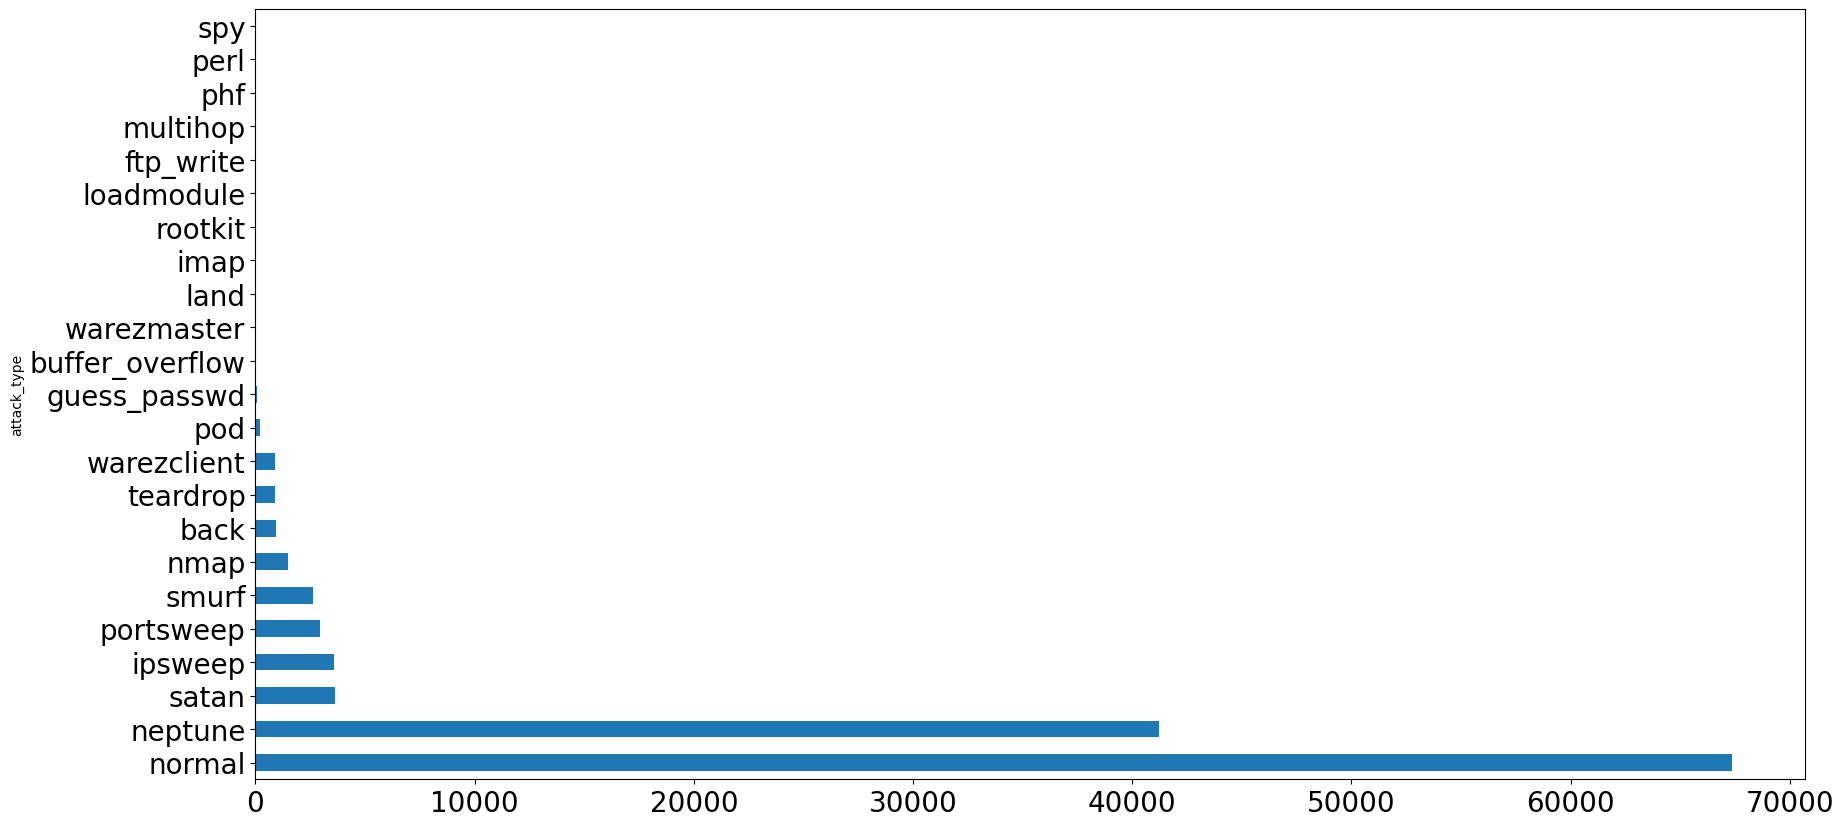

In [11]:
train_attack_types.plot(kind='barh', figsize=(20,10), fontsize=20)

<Axes: ylabel='attack_category'>

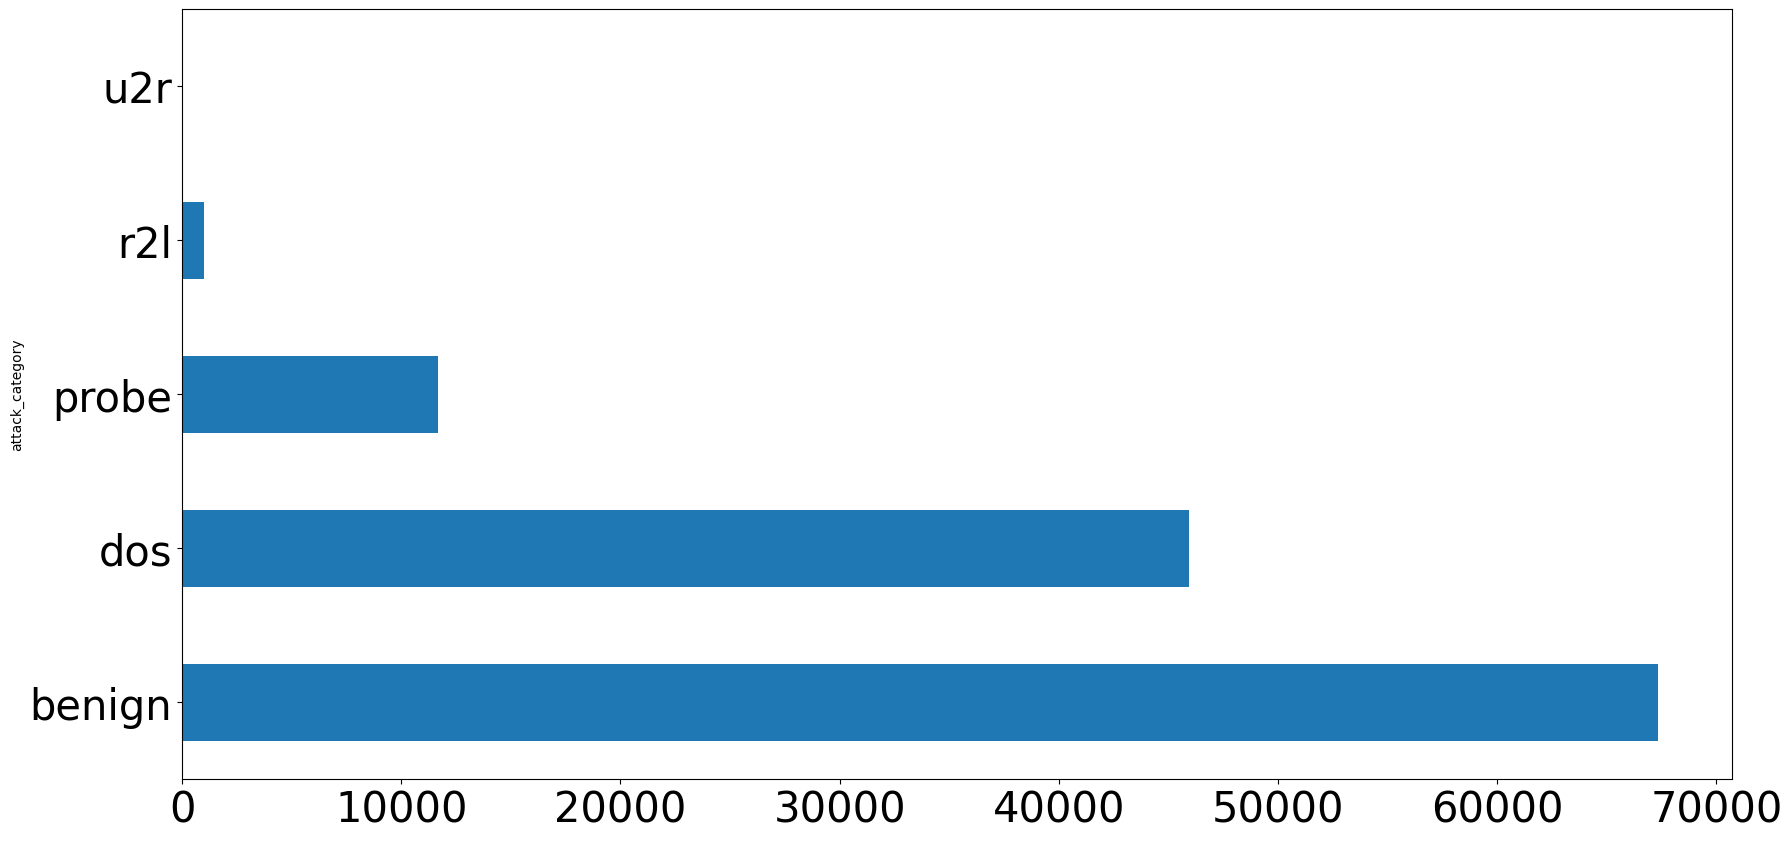

In [12]:
train_attack_cats.plot(kind='barh', figsize=(20,10), fontsize=30)

<Axes: ylabel='attack_type'>

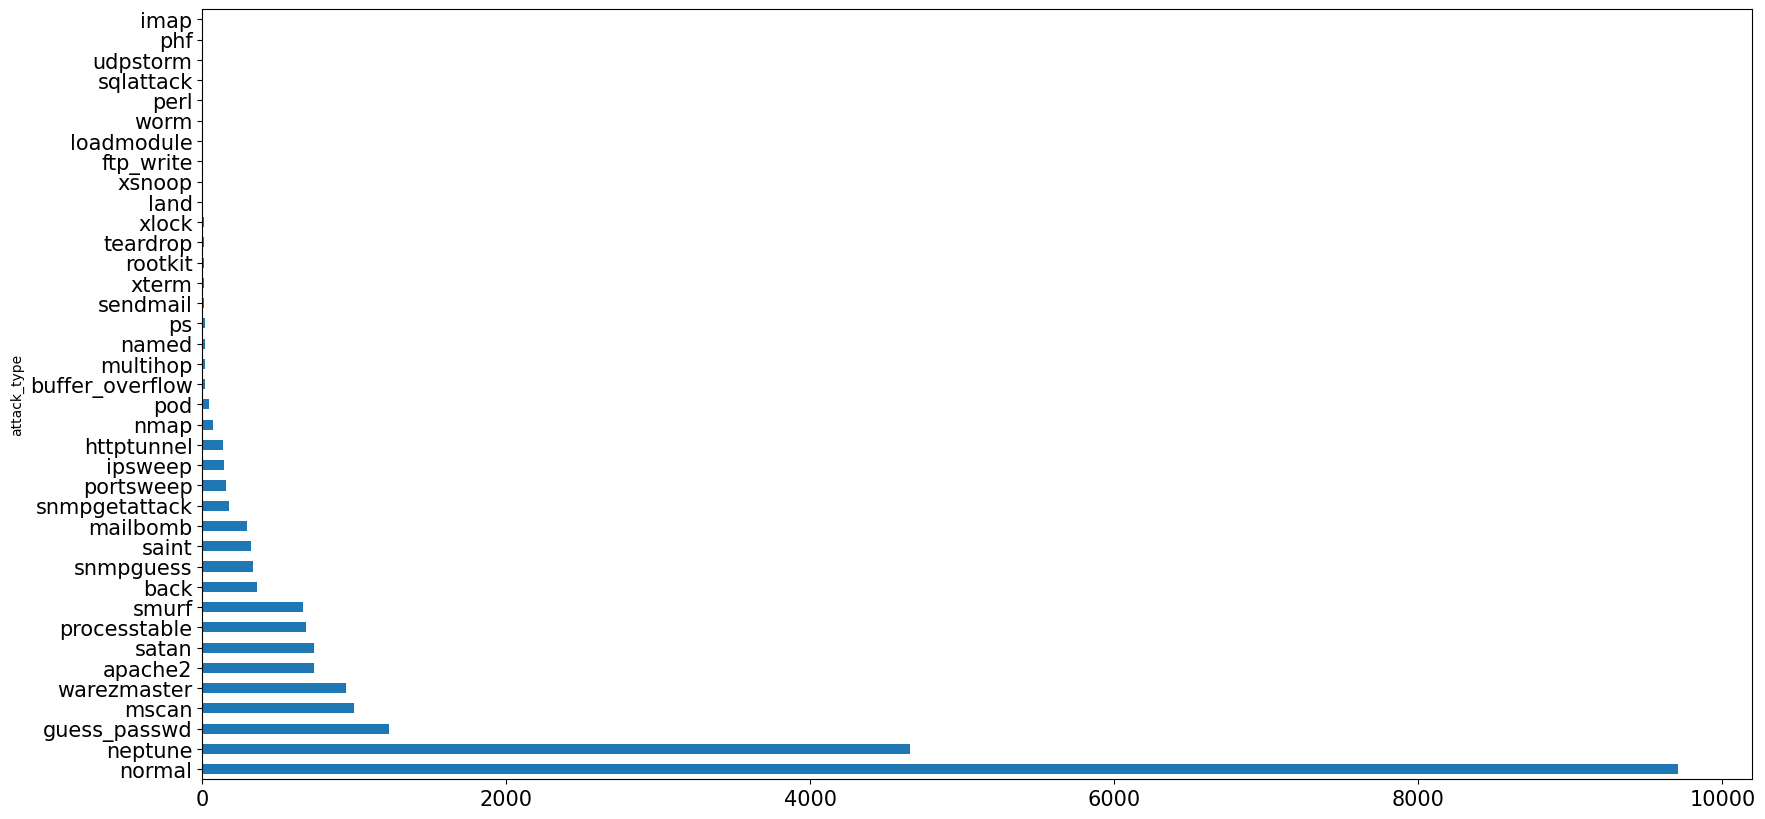

In [13]:
test_attack_types.plot(kind='barh', figsize=(20,10), fontsize=15)

<Axes: ylabel='attack_category'>

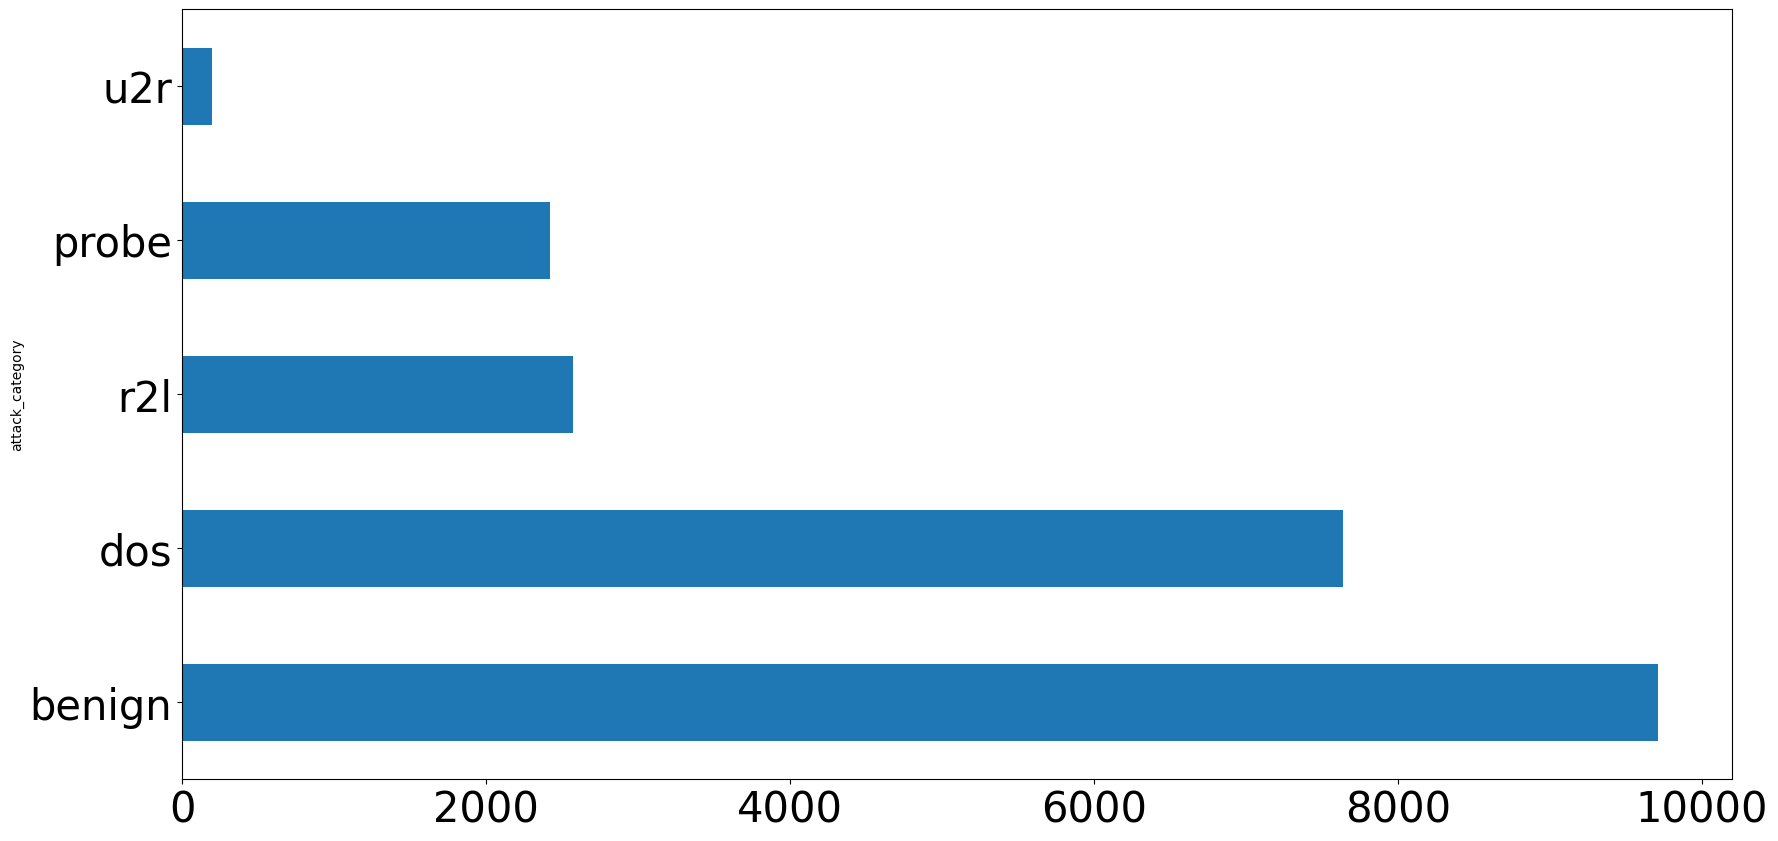

In [14]:
test_attack_cats.plot(kind='barh', figsize=(20,10), fontsize=30)

In [15]:
# Let's take a look at the binary features
# By definition, all of these features should have a min of 0.0 and a max of 1.0

train_df[binary_cols].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
land,125973.0,0.000198,0.014086,0.0,0.0,0.0,0.0,1.0
logged_in,125973.0,0.395736,0.489010,0.0,0.0,0.0,1.0,1.0
root_shell,125973.0,0.001342,0.036603,0.0,0.0,0.0,0.0,1.0
su_attempted,125973.0,0.001103,0.045154,0.0,0.0,0.0,0.0,2.0
is_host_login,125973.0,0.000008,0.002817,0.0,0.0,0.0,0.0,1.0
is_guest_login,125973.0,0.009423,0.096612,0.0,0.0,0.0,0.0,1.0


In [16]:
# Wait a minute... the su_attempted column has a max value of 2.0?

train_df.groupby(['su_attempted']).size()

su_attempted
0    125893
1        21
2        59
dtype: int64

In [17]:
# Let's fix this discrepancy and assume that su_attempted=2 -> su_attempted=0

train_df['su_attempted'].replace(2, 0, inplace=True)
test_df['su_attempted'].replace(2, 0, inplace=True)
train_df.groupby(['su_attempted']).size()

su_attempted
0    125952
1        21
dtype: int64

In [18]:
# Next, we notice that the num_outbound_cmds column only takes on one value!

train_df.groupby(['num_outbound_cmds']).size()

num_outbound_cmds
0    125973
dtype: int64

In [19]:
# Now, that's not a very useful feature - let's drop it from the dataset

train_df.drop('num_outbound_cmds', axis = 1, inplace=True)
test_df.drop('num_outbound_cmds', axis = 1, inplace=True)
numeric_cols.remove('num_outbound_cmds')

## Data preparation

In [20]:
train_Y = train_df['attack_category']
train_x_raw = train_df.drop(['attack_category','attack_type'], axis=1)
test_Y = test_df['attack_category']
test_x_raw = test_df.drop(['attack_category','attack_type'], axis=1)

In [21]:
combined_df_raw = pd.concat([train_x_raw, test_x_raw])
combined_df = pd.get_dummies(combined_df_raw, columns=nominal_cols, drop_first=True)

train_x = combined_df[:len(train_x_raw)]
test_x = combined_df[len(train_x_raw):]

# Store dummy variable feature names
dummy_variables = list(set(train_x)-set(combined_df_raw))

In [22]:
# Let's proceed with StandardScaler- Apply to all the numeric columns
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler().fit(train_x[numeric_cols])

train_x[numeric_cols] = \
    standard_scaler.transform(train_x[numeric_cols])

test_x[numeric_cols] = \
    standard_scaler.transform(test_x[numeric_cols])

In [23]:
train_Y_bin = train_Y.apply(lambda x: 0 if x is 'benign' else 1)
test_Y_bin = test_Y.apply(lambda x: 0 if x is 'benign' else 1)

## Dealing with class imbalance

In [24]:
test_Y.value_counts().apply(lambda x: x/float(len(test_Y)))

attack_category
benign    0.430758
dos       0.338715
r2l       0.114177
probe     0.107479
u2r       0.008872
Name: count, dtype: float64

In [25]:
train_Y.value_counts().apply(lambda x: x/float(len(train_Y)))

attack_category
benign    0.534583
dos       0.364578
probe     0.092528
r2l       0.007899
u2r       0.000413
Name: count, dtype: float64

In [26]:
print(pd.Series(train_Y).value_counts())

attack_category
benign    67343
dos       45927
probe     11656
r2l         995
u2r          52
Name: count, dtype: int64


In [49]:
from imblearn.over_sampling import SMOTE
strategy = {'r2l': 11_656, 'u2r': 11_656}
sm = SMOTE(sampling_strategy='auto', random_state=0)
train_x_sm, train_Y_sm = sm.fit_resample(train_x, train_Y)
print(pd.Series(train_Y_sm).value_counts())

attack_category
benign    67343
dos       67343
r2l       67343
probe     67343
u2r       67343
Name: count, dtype: int64


In [52]:
from imblearn.under_sampling import RandomUnderSampler

mean_class_size = int(pd.Series(train_Y).value_counts().sum()/5)

sampling_strategy = {'benign': mean_class_size,
                     'dos': mean_class_size,
                     'probe': mean_class_size,
                     'r2l': mean_class_size,
                     'u2r': mean_class_size}

rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=0, replacement=True)
train_x_rus, train_Y_rus = rus.fit_resample(train_x_sm, train_Y_sm)
print(pd.Series(train_Y_rus).value_counts())

attack_category
benign    25194
dos       25194
probe     25194
r2l       25194
u2r       25194
Name: count, dtype: int64


In [53]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, zero_one_loss

classifier = DecisionTreeClassifier(random_state=17)
classifier.fit(train_x_rus, train_Y_rus)

pred_y = classifier.predict(test_x)

results = confusion_matrix(test_Y, pred_y)
error = zero_one_loss(test_Y, pred_y)

print(results)
print(error)

[[9320   73  306    6    6]
 [1036 5742  857    1    0]
 [ 140  168 2114    0    1]
 [2221    0  100  220   33]
 [  57    0   83   24   36]]
0.22675656493967355


In [55]:
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Convert string labels to numeric for LightGBM
label_mapping = {'benign': 0, 'dos': 1, 'probe': 2, 'r2l': 3, 'u2r': 4}
train_Y_rus_numeric = train_Y_rus.map(label_mapping)

# Train LightGBM model
lgb_train = lgb.Dataset(train_x_rus, label=train_Y_rus_numeric)

# Set parameters for LightGBM
params = {
    'objective': 'multiclass',
    'num_class': 5,
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

# Train the model
lgb_model = lgb.train(params, lgb_train, num_boost_round=100)

# Make predictions on test set
lgb_pred = lgb_model.predict(test_x)
lgb_pred_labels = [list(x).index(max(x)) for x in lgb_pred]

# Convert string labels to numeric for comparison
label_mapping = {'benign': 0, 'dos': 1, 'probe': 2, 'r2l': 3, 'u2r': 4}
test_Y_numeric = test_Y.map(label_mapping)

# Calculate accuracy
lgb_accuracy = accuracy_score(test_Y_numeric, lgb_pred_labels)
print(f"LightGBM Accuracy: {lgb_accuracy:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(test_Y_numeric, lgb_pred_labels, 
                          target_names=['benign', 'dos', 'probe', 'r2l', 'u2r']))

# Print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(test_Y_numeric, lgb_pred_labels))

LightGBM Accuracy: 0.7756

Classification Report:
              precision    recall  f1-score   support

      benign       0.68      0.97      0.80      9711
         dos       0.96      0.77      0.85      7636
       probe       0.84      0.74      0.79      2423
         r2l       0.96      0.14      0.25      2574
         u2r       0.71      0.12      0.21       200

    accuracy                           0.78     22544
   macro avg       0.83      0.55      0.58     22544
weighted avg       0.82      0.78      0.75     22544


Confusion Matrix:
[[9428   70  205    4    4]
 [1626 5875  135    0    0]
 [ 461  166 1794    2    0]
 [2198    0    5  365    6]
 [ 166    0    1    9   24]]


In [ ]:
import xgboost as xgb

# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(train_x_rus, label=train_Y_rus_numeric)
dtest = xgb.DMatrix(test_x)

# Set parameters for XGBoost
params = {
    'objective': 'multi:softprob',
    'num_class': 5,
    'eval_metric': 'mlogloss',
    'booster': 'gbtree',
    'max_depth': 6,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.9,
    'silent': 1,
    'seed': 42
}

# Train the model
xgb_model = xgb.train(params, dtrain, num_boost_round=100)

# Make predictions on test set
xgb_pred = xgb_model.predict(dtest)
xgb_pred_labels = [list(x).index(max(x)) for x in xgb_pred]

# Convert string labels to numeric for comparison
test_Y_numeric = test_Y.map(label_mapping)

# Calculate accuracy
xgb_accuracy = accuracy_score(test_Y_numeric, xgb_pred_labels)
print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(test_Y_numeric, xgb_pred_labels, 
                          target_names=['benign', 'dos', 'probe', 'r2l', 'u2r']))

# Print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(test_Y_numeric, xgb_pred_labels))

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FeatureExtractor(nn.Module):
    def __init__(self,
                 input_dim: int = 120,
                 mcl_filters: int = 10,
                 conv1_out: int = 32,
                 conv2_out: int = 16,
                 lstm_hidden: int = 64,
                 attn_dim: int = 32,
                 num_classes: int = 5):
        """
        input_dim: number of input features per sample (e.g. 120)
        num_classes: number of target classes for classification
        """
        super().__init__()

        # Mean Convolutional Layer (MCL)
        self.mcl = nn.Conv1d(in_channels=1,
                             out_channels=mcl_filters,
                             kernel_size=1)

        # Two-stage CNN
        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=conv1_out,
                               kernel_size=(1, input_dim // mcl_filters),
                               bias=True)
        self.conv2 = nn.Conv2d(in_channels=conv1_out,
                               out_channels=conv2_out,
                               kernel_size=(5, 5),
                               padding=0,
                               bias=True)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)

        # Bidirectional LSTM
        self.bilstm = nn.LSTM(input_size=mcl_filters,
                              hidden_size=lstm_hidden,
                              num_layers=1,
                              batch_first=True,
                              bidirectional=True)

        # Self-attention
        self.attn_proj = nn.Linear(2 * lstm_hidden, attn_dim, bias=True)
        self.attn_score = nn.Linear(attn_dim, 1, bias=False)

        # Compute CNN feature dimension dynamically
        with torch.no_grad():
            dummy = torch.zeros(1, 1, mcl_filters, input_dim)
            c1 = F.relu(self.conv1(dummy))
            c2 = F.relu(self.conv2(c1))
            p = self.pool(c2)
            cnn_feat_dim = p.view(1, -1).size(1)

        # Classification head for num_classes
        self.classifier = nn.Linear(cnn_feat_dim + 2 * lstm_hidden,
                                    num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B = x.size(0)

        # MCL
        x_mcl = x.unsqueeze(1)
        mcl_out = F.relu(self.mcl(x_mcl))  # (B, mcl_filters, input_dim)

        # CNN path
        cnn_in = mcl_out.unsqueeze(1)
        c1 = F.relu(self.conv1(cnn_in))
        c2 = F.relu(self.conv2(c1))
        p = self.pool(c2)
        cnn_feat = p.view(B, -1)

        # LSTM + Attention path
        seq = mcl_out.permute(0, 2, 1)
        lstm_out, _ = self.bilstm(seq)
        u = torch.tanh(self.attn_proj(lstm_out))
        scores = self.attn_score(u).squeeze(-1)
        alpha = F.softmax(scores, dim=1)
        attn_feat = torch.sum(lstm_out * alpha.unsqueeze(-1), dim=1)

        # Concatenate features
        features = torch.cat([cnn_feat, attn_feat], dim=1)
        # Classifier
        logits = self.classifier(features)
        return logits
